# Stock Price Forecasting using Linear Regression

Steps followed in this project:
1. Fetching relevant Quarterly Stock data for the utility industry as per the GICS using the Sub-Industry codes from WRDS
2. Importing the data file into the Jupyter notebook and perform data cleaning
3. Filtering by the companies still in existence and companies with a minimum chosen number of data points
4. Using linear regression to perform trend analysis and forecast values for 4 quarters in 2020 and 2 quarters in 2021
5. Plotting the historic and forecasted prices to provide a visual representation of the stock movements
6. Calculating and storing expected stock returns and volatility, and computing the Sharpe Ratio
7. Constructing 2 portfolio optimization strategies: using Sharpe Ratio and, using random stock and weight combinations

# Importing Dependencies

In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
import random

# Importing Data File

In [3]:
#import data
data = pd.read_excel("utilities.xlsx")

# Data Cleaning

In [4]:
#renaming column names
data = data.rename(columns={"Fiscal Year": "Year"})
data = data.rename(columns={"Fiscal Quarter": "Quarter"})
data = data.rename(columns={"Ticker Symbol": "Ticker"})
data = data.rename(columns={"Company Name": "Name"})
data = data.rename(columns={"Price Close - Quarter": "Price"})

#dropping data points for the year 1999 and 2020 to create consistent dataset
data = data[data["Year"] != 1999]
data = data[data["Year"] != 2020]

#dropping all rows with no values for price
data = data.dropna(subset = ["Price"])

#keeping companies with minimum 8 data points since train test split is 75% 25%
#25% of 8 is 2 which is essential for the model to perform well
#if the test data has less than 2 samples then the model fails
minimum = 8
for each in data.Ticker.unique():
    if ((data.loc[data.Ticker == each]).shape[0] < minimum):
        data = data[data["Ticker"] != each]

#storing clean data in a dataframe
utilities = pd.DataFrame()
for each in ((data[data["Year"] == 2019])[(data[data["Year"] == 2019])["Quarter"] == 4]).Ticker:
    utilities = utilities.append(data[data["Ticker"] == each],ignore_index=True)

# Creating a function to Forecast Stock Prices

In [5]:
#defining the number of periods we want to forecast
#here we are forecasting 4 periods in 2020, 2 periods in 2021
twentyone = 2
twenty = 4

#creating function which can be called with any company's ticker to forecast future stock prices
def forecast_values(name):
    
    #subsetting the data points for the company under observation
    data = utilities.loc[utilities["Ticker"] == name]
    
    #data cleaning
    data = data.reset_index()
    data = data.drop("index",axis = 1)    
    
    #selecting closing prices
    df = pd.DataFrame(data[["Price"]])
    
    #adding total number of periods
    forecast = twenty + twentyone
    
    #creating a column called prediction with shifted values
    df["Prediction"] = df[["Price"]].shift(-forecast)
    
    #creating a variable of independent values
    X = np.array(df.drop(["Prediction"],1))[:-forecast]
    
    #creating a variable of target values    
    y = np.array(df["Prediction"])[:-forecast]
    
    #defining split of train and test data
    split = 75
    #splitting train and test data
    x_train , x_test, y_train, y_test = train_test_split(X,y,test_size = (1-(split/100)))    
    
    #Linear Regression model
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    
    x_forecast = np.array(df.drop(["Prediction"],1))[-forecast:]
    
    #storing forecasted values
    prediction = pd.Series(lr.predict(x_forecast))

    #plotting historic and predicted values    
    df1 = pd.DataFrame(df["Price"])
    df1 = df1["Price"].append(prediction)
    df1 = df1.reset_index()
    df1 = df1.drop(["index"],1)
    df1 = df1.rename({0:"Price"},axis = 'columns')
    
    #creating labels for x axis
    intervals = 6
    time = []
    for j in np.arange(0, (((data.Year).append(pd.Series([2020]*4+[2021]*twentyone),ignore_index=True)).shape[0]), step=(int(((data.Year).append(pd.Series([2020]*4+[2021]*twentyone),ignore_index=True)).shape[0]/intervals))):
        time.append(str((data.Year).append(pd.Series([2020]*4+[2021]*twentyone),ignore_index=True)[j])+" Q"+str((data.Quarter).append(pd.Series([x-4 if x>4 else x for x in range(1,forecast+1)]),ignore_index=True)[j]))
    
    plt.plot(df1["Price"],label = "Predicted",color = "blue",linewidth = 2)
    plt.plot(data["Price"],label = "Historic",color = "green",linewidth = 2)
    plt.xticks(np.arange(0, (((data.Year).append(pd.Series([2020]*4+[2021]*twentyone),ignore_index=True)).shape[0]), step=(int(((data.Year).append(pd.Series([2020]*4+[2021]*twentyone),ignore_index=True)).shape[0]/intervals))), time,rotation = 45)
    plt.legend()
    plt.grid(alpha = 0.7)
    plt.margins(x = 0)
    plt.xlabel('Date')
    plt.ylabel('Price ('+data["Ticker"][0]+')')
    plt.show()
    
    
    #adding forecasted value to dataframe of the ticker
    data = data.append(pd.DataFrame({data.columns[0]: [2020]*4+[2021]*twentyone,
              data.columns[1]: [x-4 if x>4 else x for x in range(1,forecast+1)],
              data.columns[2]:(data["Ticker"][0:forecast]),
              data.columns[3]:(data["Name"][0:forecast]),
              data.columns[4]: np.array(prediction)}),ignore_index=True)
    
    forecasted = (pd.Series((df.Price)[len(df.Price)-1])).append(prediction,ignore_index=True)
    
    #returning values
    return data,forecasted,df

# Combining in-sample and out-of-sample data and calculating Stock KPI

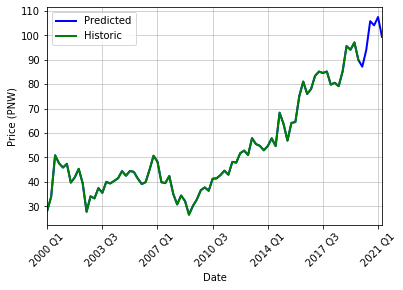

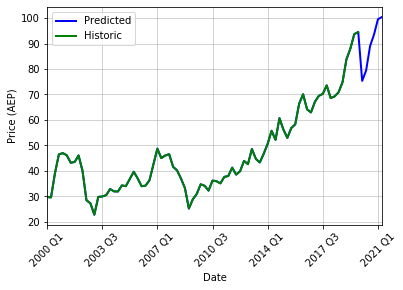

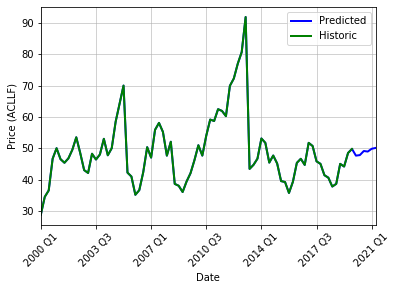

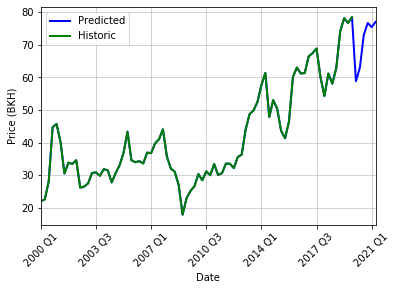

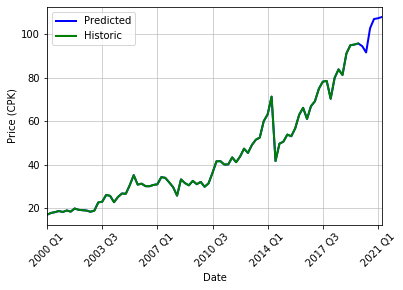

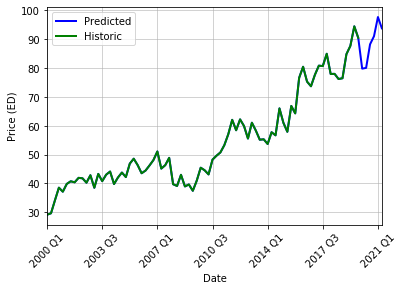

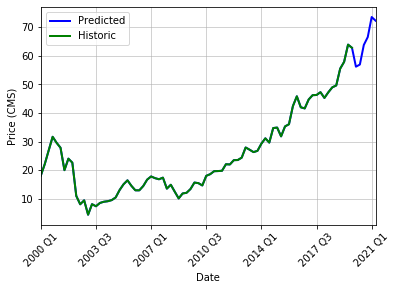

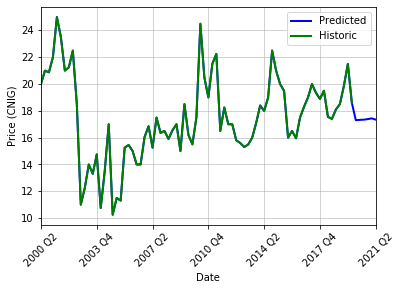

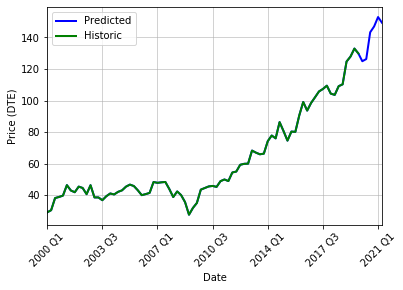

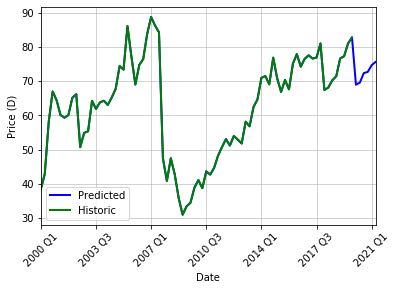

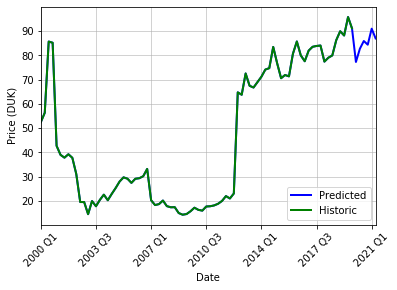

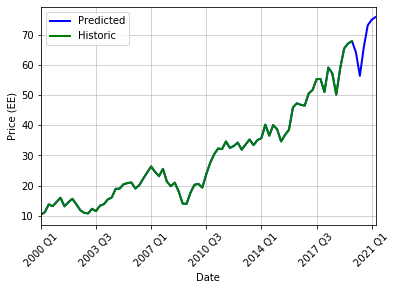

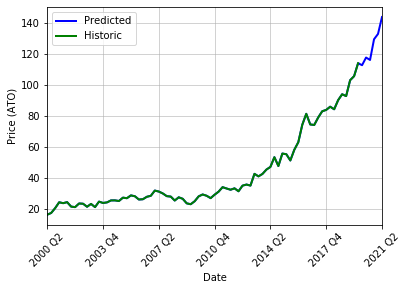

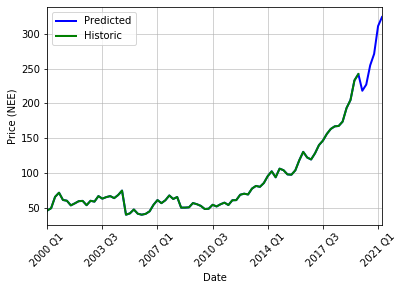

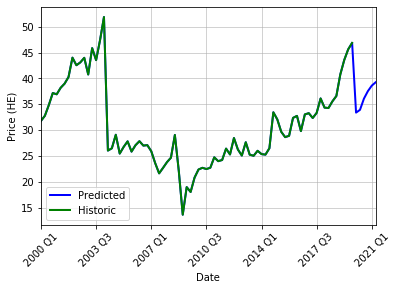

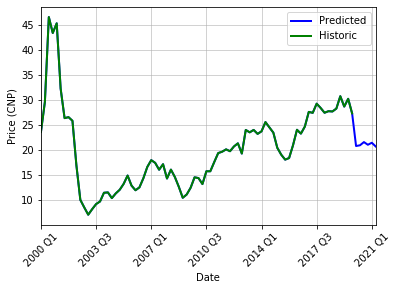

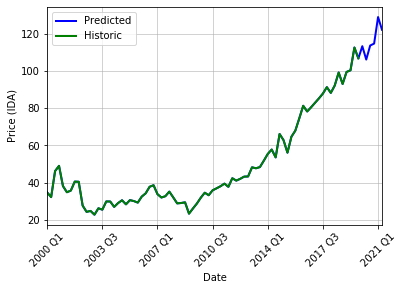

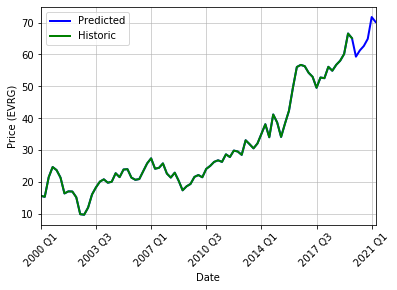

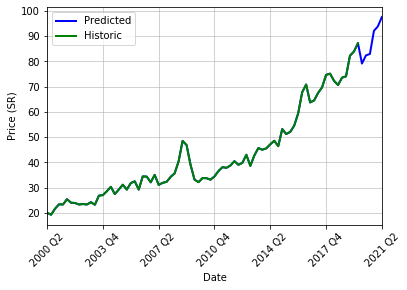

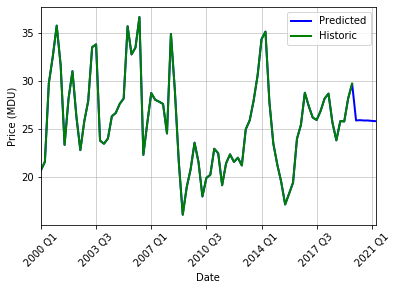

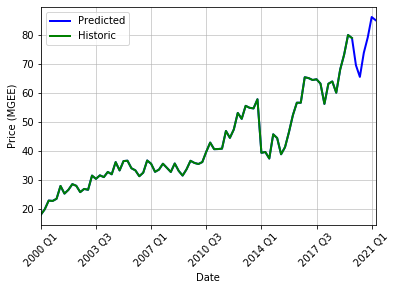

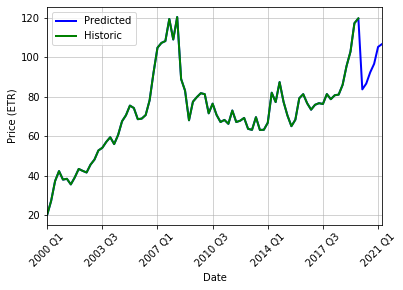

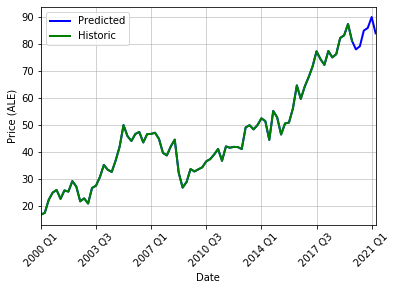

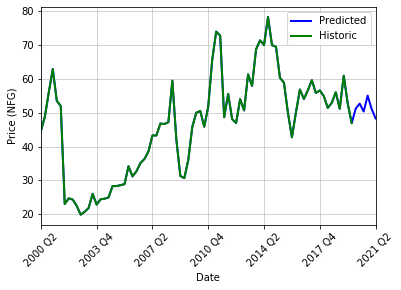

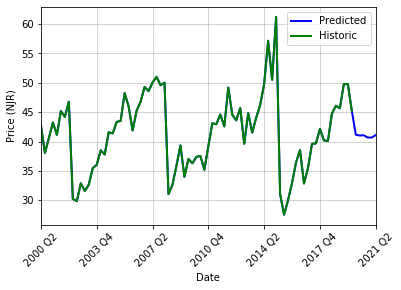

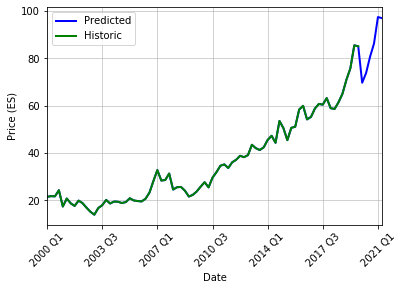

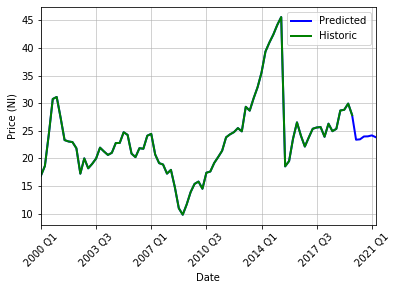

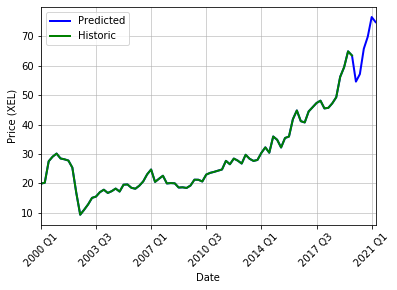

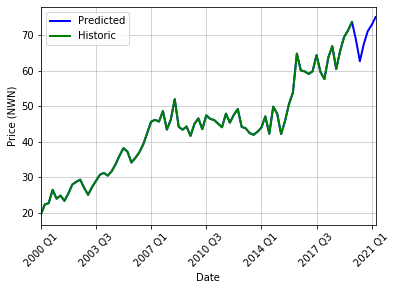

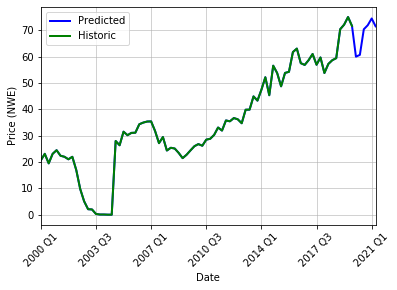

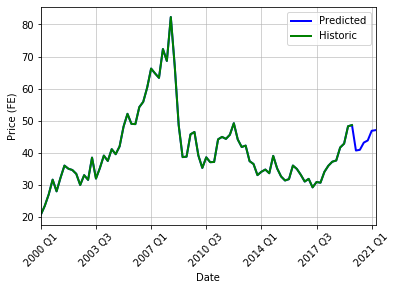

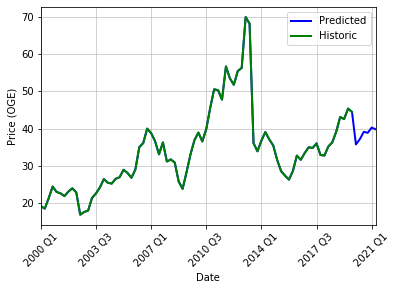

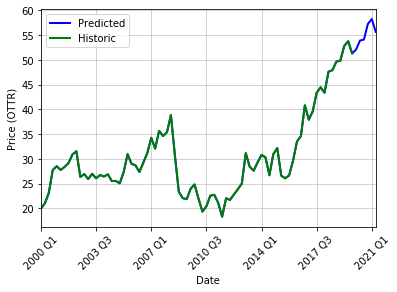

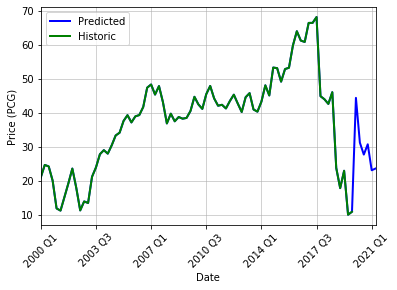

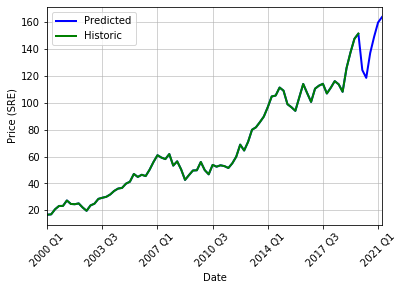

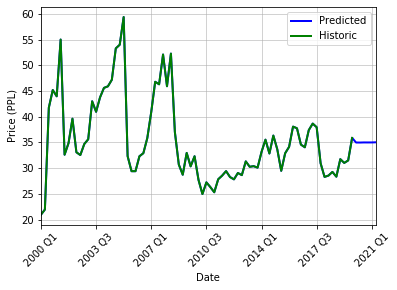

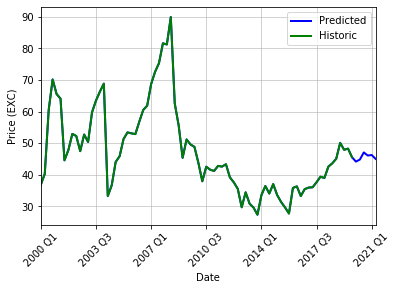

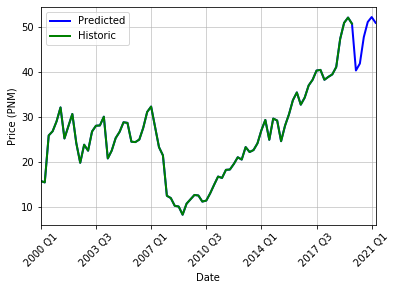

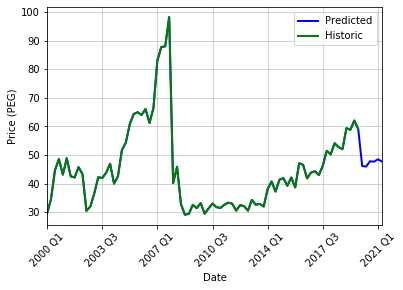

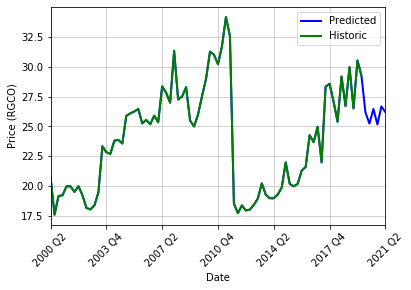

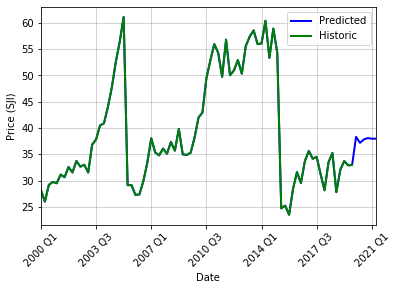

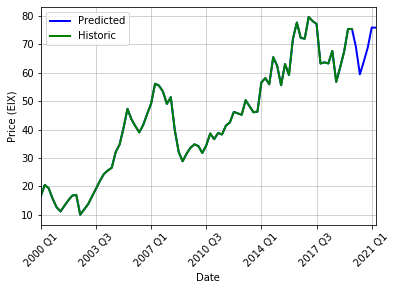

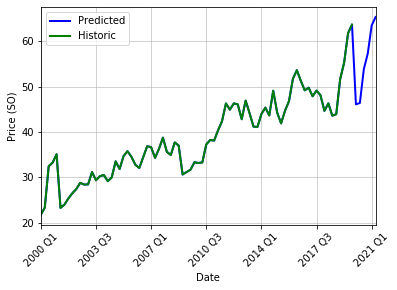

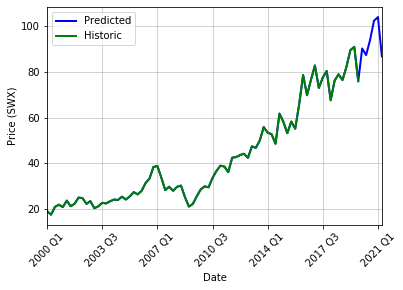

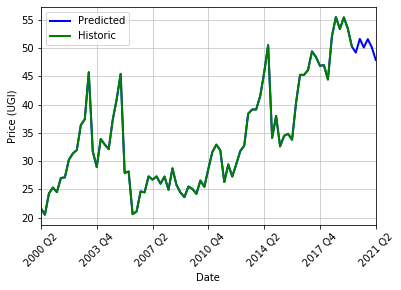

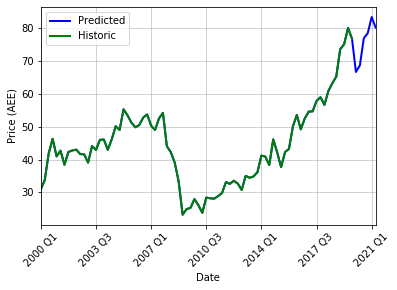

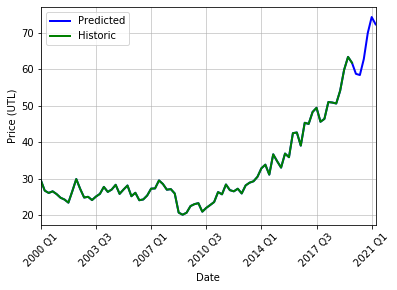

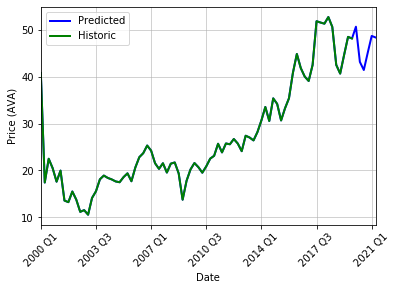

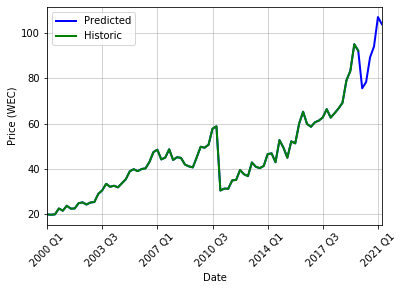

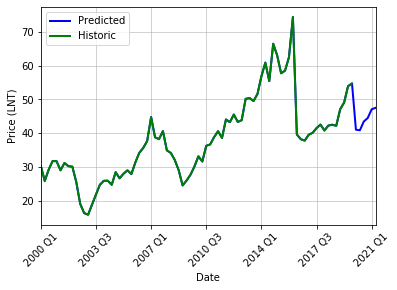

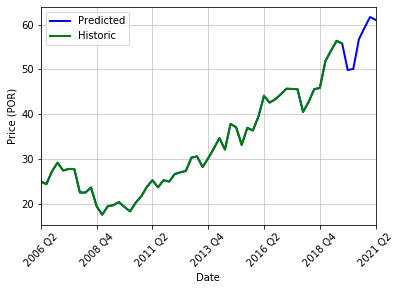

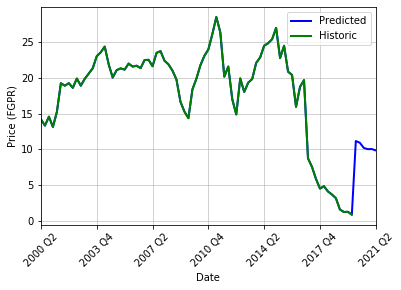

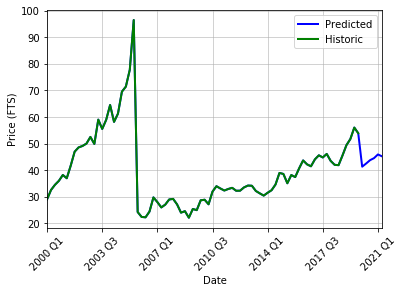

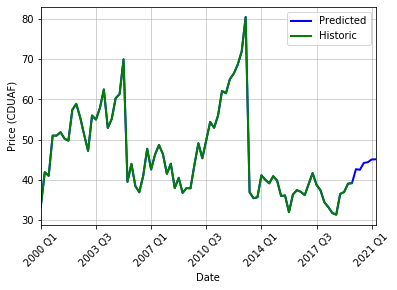

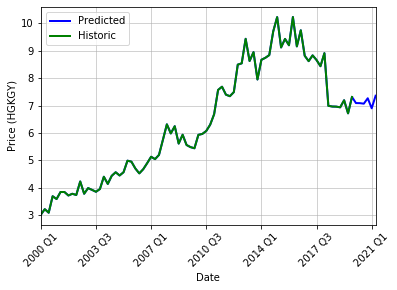

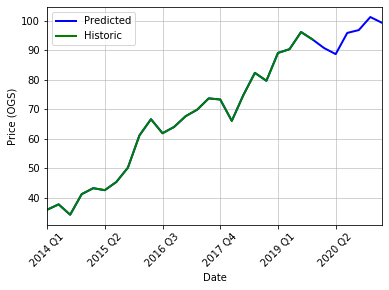

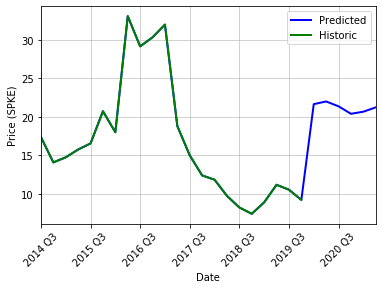

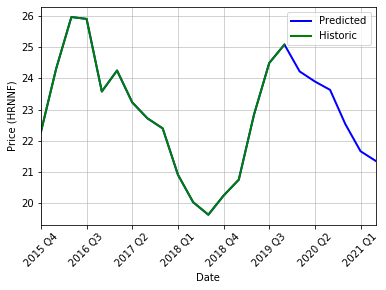

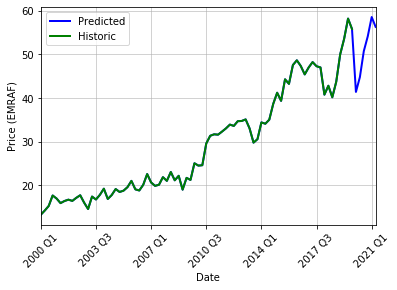

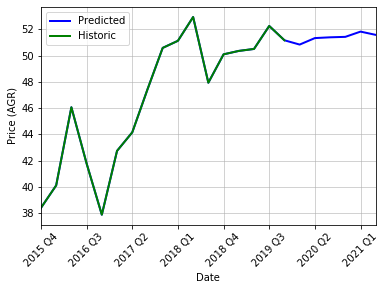

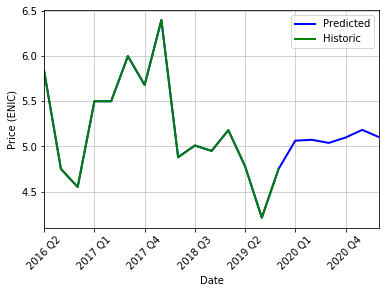

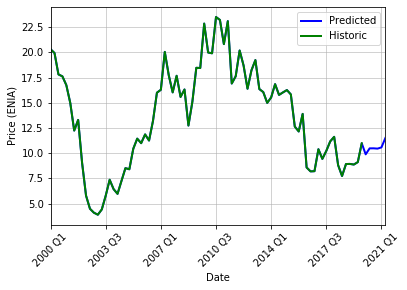

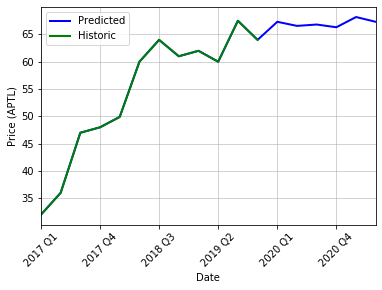

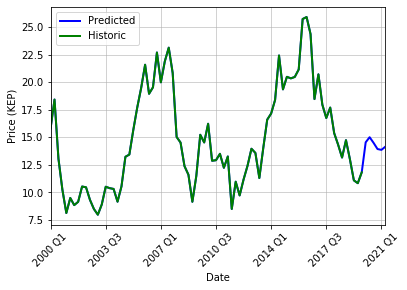

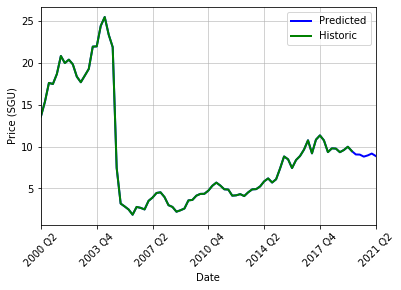

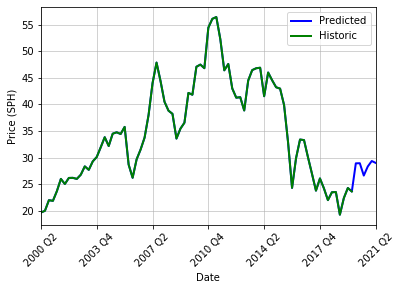

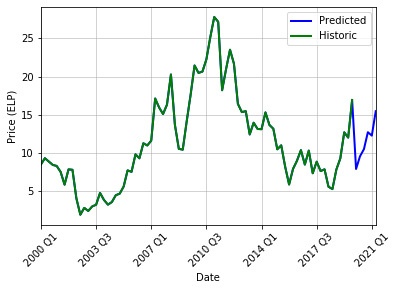

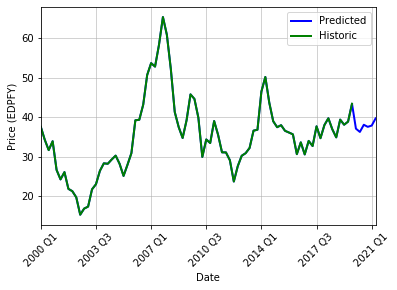

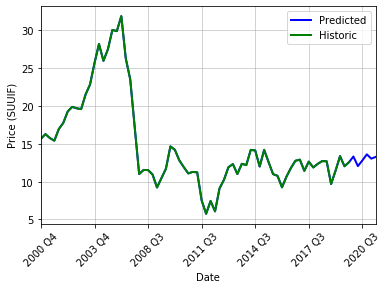

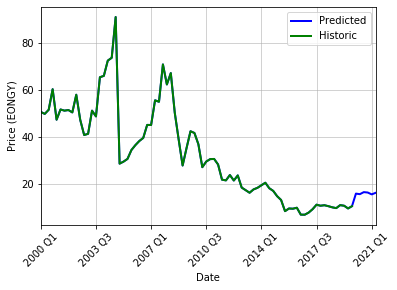

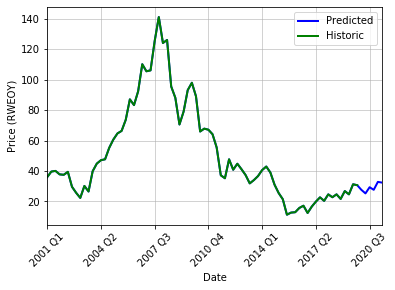

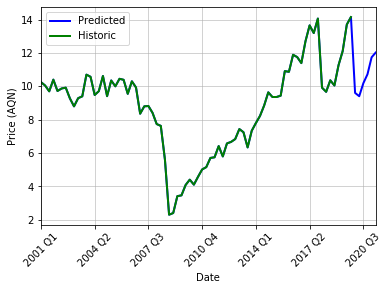

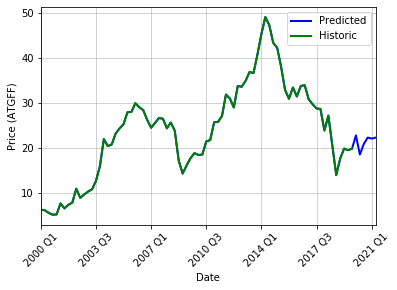

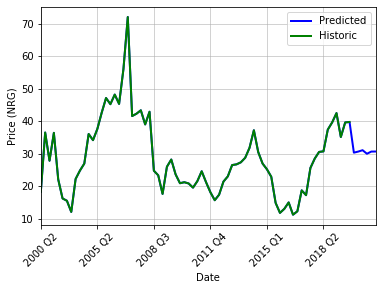

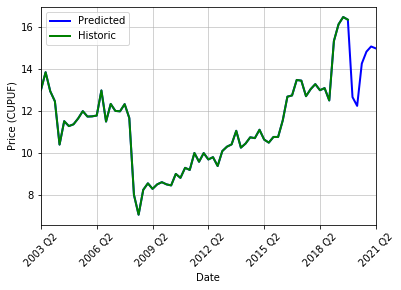

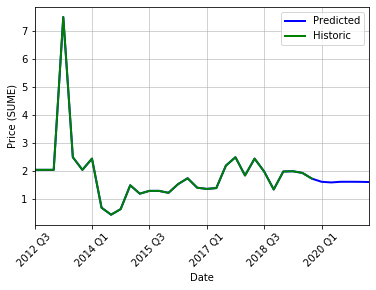

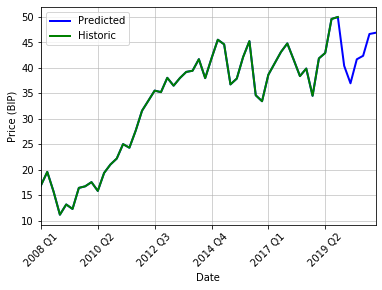

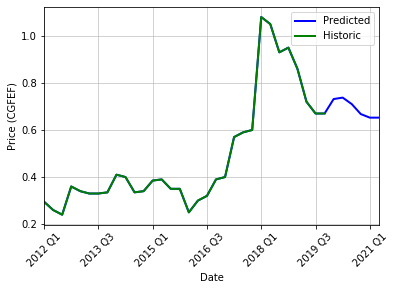

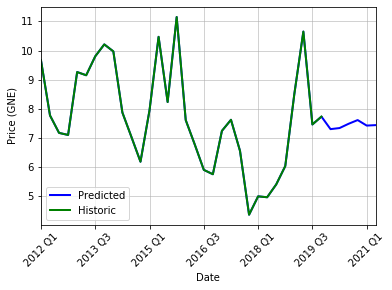

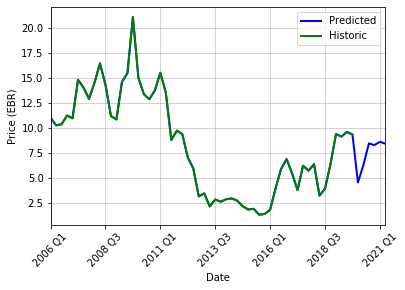

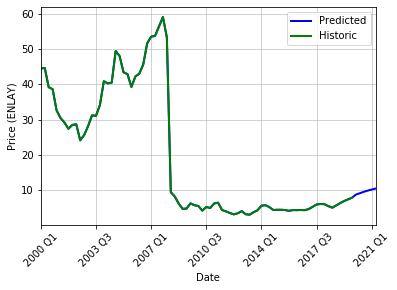

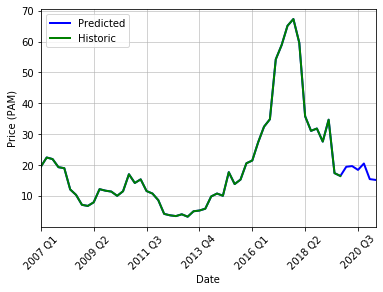

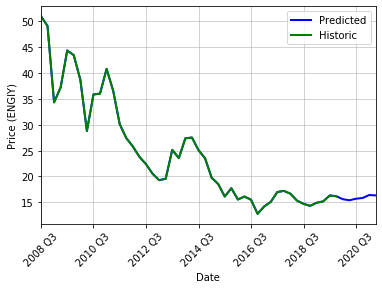

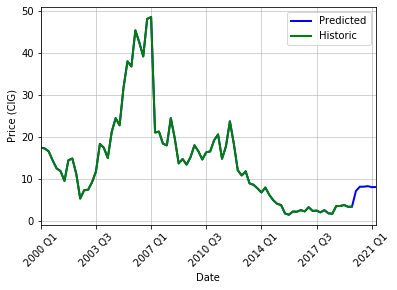

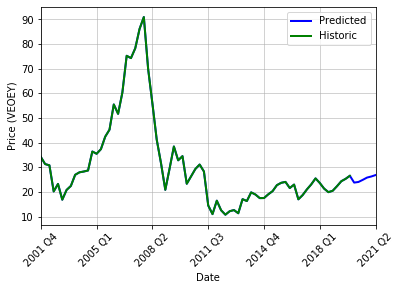

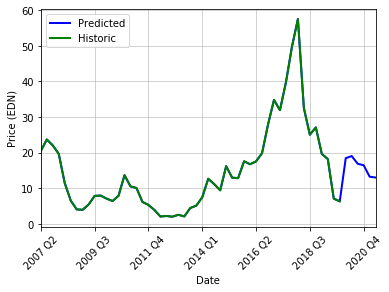

In [6]:
#creating an empty dataframe to append all forecast values
data_w_forecast = pd.DataFrame(columns = [utilities.columns[0],
                    utilities.columns[1],utilities.columns[2],
                    utilities.columns[3],utilities.columns[4]])

#creating a new dataframe to store outcome of the model
outcomes = pd.DataFrame(columns = ["Ticker","Returns","Volatility","Sharpe_Ratio"])

#iterating over every company in utilities and calling the forecase values function to obtain forecasted values
#calculating and storing the forecasted prices, volatility and sharpe ratio for all companies
for every in utilities.Ticker.unique():
    data,future,old = forecast_values(every)
    data_w_forecast = data_w_forecast.append(data,ignore_index=True)
    outcomes = outcomes.append({'Ticker':every,'Returns':(round((((future[6]-future[0])/future[0])*100),2)), \
                                
        'Volatility':(round((math.sqrt(np.var(old.Price))),2)),\
            
        'Sharpe_Ratio':((((future[6]-future[0])/future[0])*100))/((math.sqrt(np.var(old.Price))))}, \
                               ignore_index=True)

# Creating a function to fetch Forecasted Stock values

In [7]:
#this function can be used to fetch forecasted values by company ticker
def get_data(name):
    return data_w_forecast.loc[data_w_forecast["Ticker"] == name]

# Data Preparation for Portfolio Creation 

In [8]:
# Removing all companies that are expected to lose money 
outcomes = (outcomes.loc[outcomes.Returns > 0])
outcomes = (outcomes.reset_index()).drop('index',1)

# Portfolio Creation Method 1

In [9]:
#initializing variables
companies = []
weight = []
minimum = 0.01
recomm = {}
overall_ret = 0
overall_risk = 0

#iterating over each company and storing company names, weights and calculating overall returns and risk of the portfolio
for i in (outcomes.Sharpe_Ratio.loc[outcomes.Sharpe_Ratio > round(((np.sum(outcomes.Sharpe_Ratio))*minimum),2)]).iteritems():
    companies.append(outcomes.Ticker[i[0]])
for i in np.array(((outcomes.Sharpe_Ratio.loc[outcomes.Sharpe_Ratio > round(((np.sum(outcomes.Sharpe_Ratio))*minimum),2)]).reset_index()).drop("index",1)):
    weight.append(round((i[0]/np.sum(np.array(((outcomes.Sharpe_Ratio.loc[outcomes.Sharpe_Ratio > round(((np.sum(outcomes.Sharpe_Ratio))*minimum),2)]).reset_index()).drop("index",1)))),2))
for i in range(len(companies)):
    overall_ret += (float((outcomes.loc[outcomes.Ticker == companies[i]])["Returns"])*weight[i])
    overall_risk += (float((outcomes.loc[outcomes.Ticker == companies[i]])["Volatility"])*weight[i])
    recomm[companies[i]] = weight[i]

#printing values
print(recomm)
print(overall_ret)
print(overall_risk)

{'PCG': 0.04, 'FGPR': 0.71, 'SPKE': 0.08, 'ENIC': 0.06, 'KEP': 0.02, 'EONGY': 0.01, 'CIG': 0.05, 'EDN': 0.04}
786.0944000000001
7.3911999999999995


# Portfolio Creation Method 2

In [21]:
overall_ret = 0
recomm = {}

#producing 1000 portfolios with different companies and weights to find optimum returns and risk tradeoff
for i in range(1000):
    folio_ret = 0
    folio_risk = 0
    folio = []
    
    mass = (np.random.dirichlet(np.ones(random.randint(1,len(outcomes.Ticker.unique()))),size=1))[0]
    names = np.random.choice(np.arange(0,len(outcomes.Ticker.unique()),1),len(mass))
    
    for j in range(len(names)):
        folio.append(outcomes.Ticker[j])
        folio_ret+=((outcomes.Returns[names[j]])*(mass[j]))
        folio_risk+=((outcomes.Volatility[names[j]])*(mass[j]))

    if overall_ret < folio_ret:
        overall_ret = folio_ret
        overall_risk = folio_risk
        companies = folio
        weight = mass
        
for i in range(len(companies)):
    recomm[companies[i]] = round(weight[i],2)

#printing values
print(recomm)
print(overall_ret)
print(overall_risk)

{'PNW': 0.79, 'AEP': 0.1, 'ACLLF': 0.12}
841.1108852601519
7.975683229020577
